# 1. Data preprocessing

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
import re
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

# Data sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
# Read data
df1 = pd.read_json('../Data/domain1_train_data.json', lines=True)
df2 = pd.read_json('../Data/domain2_train_data.json', lines=True)

# Define Domains
df1['domain'], df2['domain'] = 1, 2

# Split set 1
x1_tr, x_dv = train_test_split(df1, stratify=df1['label'], random_state=0, test_size=0.2)
# Split set 2
x2_1 = df2[df2['label'] == 1].sample(500, random_state=0)
x2_0 = df2[df2['label'] == 0].sample(500, random_state=0)
x2_tr = df2[[i not in list(pd.concat([x2_1, x2_0]).reset_index()['index']) for i in df2.index]].reset_index(drop=True)
x2_dev = pd.concat([x2_1,x2_0]).reset_index(drop=True)

# Train test sets
x_train = pd.concat([x1_tr, x2_tr]).sample(frac=1).reset_index(drop=True)
x_dev_ = pd.concat([x_dv, x2_dev]).sample(frac=1).reset_index(drop=True)

# Transform numbers to strings to treat them as tokens
txt1 = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in x1_tr['text']]
txt2 = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in x2_tr['text']]
aug_txt = [re.sub(',', '', ', '.join([str(x) for x in tok])) for tok in x_train['text']]

# Final train test sets
x_tr_aug, y_train = aug_txt, x_train['label']
x_dev_, y_dev = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in x_dev_['text']], np.array(x_dev_['label'].astype('float32'))

# Print classes proportion
print(round(y_train.value_counts()/len(y_train),2))

label
0    0.81
1    0.19
Name: count, dtype: float64


# 2. Encoding

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# Tokens encoding to sparce matrix (Countv)
Cvec = CountVectorizer(ngram_range=(8,9))
x_train_c = Cvec.fit_transform(x_tr_aug)
x_dev_c = Cvec.transform(x_dev_)

In [4]:
x_train_c.shape

(16000, 5154787)

### Logistic model

In [31]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC

# Train models
cl_aug_c_w = LogisticRegression(dual=True, solver='liblinear', class_weight="balanced", C=1).fit(x_train_c, y_train)
# cl_aug_c_w = LinearSVC(class_weight="balanced", C=0.08, dual=True).fit(x_train_c, y_train)  
# cl_aug_c_w = RidgeClassifier(class_weight = "balanced", alpha=1.0, solver="sparse_cg").fit(x_train_c, y_train)

In [32]:
# Data augmentation scores
sc_aug_c_w_tr, sc_aug_c_w_ts = cl_aug_c_w.score(x_train_c, y_train), cl_aug_c_w.score(x_dev_c, y_dev)
# F1 scores
f1_aug_c_w_tr, f1_aug_c_w_ts = f1_score(y_train, cl_aug_c_w.predict(x_train_c)), f1_score(y_dev, cl_aug_c_w.predict(x_dev_c))

# Print scores
print(f'Model -DA using  Cvec-w:\ttr_acc: {sc_aug_c_w_tr:.3f}\tval_acc: {sc_aug_c_w_ts:.3f}\ttr_F1" {f1_aug_c_w_tr:.3f}\tts_F1" {f1_aug_c_w_ts:.3f}')

Model -DA using  Cvec-w:	tr_acc: 1.000	val_acc: 0.932	tr_F1" 1.000	ts_F1" 0.933


In [59]:
test = pd.read_json('../Data/test_data.json', lines=True)['text']
test = [[t for t in ls if t != 0] for ls in test]
test = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in test]
test_c = Cvec.transform(test)

preds = cl_aug_c_w.predict(test_c)
test_df = pd.DataFrame(columns = ['id', 'value'])
for idx, v in enumerate(preds):
    test_df.loc[idx] = [idx, preds[idx]]
test_df.to_csv('../Data/predictions_lr.csv', index=False)

In [52]:
df_full = pd.concat([df1, df2]).sample(frac=1).reset_index(drop=True)
txt_full = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in df_full['text']]
# Full vect
Cvec_f = CountVectorizer(ngram_range=(8,9))
x_full = Cvec_f.fit_transform(txt_full)
y_full = df_full['label']

In [54]:
cl_aug_c_a = LogisticRegression(dual=True, solver='liblinear', class_weight="balanced", C=1).fit(x_full, y_full)
cl_aug_c_b = LinearSVC(class_weight="balanced", C=0.08, dual=True).fit(x_full, y_full)  
cl_aug_c_c = RidgeClassifier(class_weight = "balanced", alpha=1.0, solver="sparse_cg").fit(x_full, y_full)

In [56]:
test = pd.read_json('../Data/test_data.json', lines=True)['text']
test = [[t for t in ls if t != 0] for ls in test]
test = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in test]
test_c = Cvec_f.transform(test)

In [57]:
pr_1 = cl_aug_c_a.predict(test_c)
pr_2 = cl_aug_c_b.predict(test_c)
pr_3 = cl_aug_c_c.predict(test_c)

In [58]:
preds = pd.DataFrame([pr_1, pr_2, pr_3]).T.mean(axis=1).astype('int')
test_df = pd.DataFrame(columns = ['id', 'value'])
for idx, v in enumerate(preds):
    test_df.loc[idx] = [idx, preds[idx]]
test_df.to_csv('../Data/predictions_ens.csv', index=False)

In [124]:
l = []
for i in range(df_.shape[0]):
    if df_.loc[i, 'lr'] == df_.loc[i, 'svc'] == df_.loc[i, 'rg']:
        l.append(df_.loc[i, 'lr'])
    else:
        l.append(round(sum(df_.loc[i])/3))
# preds = l
# test_df = pd.DataFrame(columns = ['id', 'value'])
# for idx, v in enumerate(preds):
#     test_df.loc[idx] = [idx, preds[idx]]
# test_df.to_csv('../Data/predictions.csv', index=False)

In [125]:
pd.Series(l).value_counts()

1    2079
0    1921
Name: count, dtype: int64

In [62]:
# Helper function to get model metrics
def max_pr(pr, y):
    l = []
    p, r = [], []
    min = 1
    y_ = pd.Series(y)
    for i in range(1,100):
        # ACC
        acc = sum([0 if p < i/100 else 1 for p in pr[1]] == y)/len(y)
        l.append(acc)
        # Precision
        ind_0 = y_[y_==0].index
        prec = sum([0 if p < i/100 else 1 for p in pr[1][ind_0]] == y_[y_==0])/len(ind_0)
        p.append(prec)
        # Recall
        ind_1 = y_[y_==1].index
        rec = sum([0 if p < i/100 else 1 for p in pr[1][ind_1]] == y_[y_==1])/len(ind_1)
        r.append(rec)
        # Closest point
        if abs((acc-prec)+(acc-rec)+(rec-prec)/3) < min:
            min = abs((acc-prec)+(acc-rec)+(rec-prec)/3)
            ind = i

    print(f'Acc: {l[ind-1]:.3f}, Precision: {p[ind-1]:.3f}, Recall: {r[ind-1]:.3f}, Closest point: {ind-1:.3f}')
    return l, p, r, ind-1

# Helper function to plot model probabilities
def plot_ptobs(p_tr, p_dv, acc, prec, rec):
    # Plot Training probabilities
    fig = plt.figure(figsize=(18, 10))
    fig.suptitle('Probabilities distribution')
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.scatter([i for i in range(len(y_train))], p_tr[0], c=y_train)
    ax1.set_title('Training probabilities')
    ax1.set_xlabel('Observation')
    ax1.set_ylabel('Probability')
    ax1.legend(['Label 1','Label 0'])
    # Plot Test probabilities
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.scatter([i for i in range(len(y_dev))], p_dv[0], c=y_dev)
    ax2.set_title('Dev probabilities')
    ax2.set_xlabel('Observation')
    ax2.set_ylabel('Probability')
    ax2.legend(['Label 1','Label 0'])
    # Plot test thresholds
    ax3 = fig.add_subplot(2, 2, 3) 
    ax3.plot(acc, ls='--')
    ax3.plot(prec)
    ax3.plot(rec)
    ax3.vlines(min, 0, 1, colors='r', ls=':')
    ax3.set_title('Threshold tradeoff')
    ax3.set_xlabel('Threshold')
    ax3.set_ylabel('Probability')
    ax3.legend(['Accuracy','Precision','Recall', 'Threshold'])

    plt.show()

In [63]:
p_tr = cl_aug_c_w.predict_proba(x_train_c).T
p_dv = cl_aug_c_w.predict_proba(x_dev_c).T
acc, prec, rec, min = max_pr(p_dv, y_dev)
plot_ptobs(p_tr, p_dv, acc, prec, rec)

AttributeError: 'RidgeClassifier' object has no attribute 'predict_proba'

### Undersampling and oversampling LR

In [110]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=3)
x_train_c_ = svd.fit_transform(x_train_c)
x_dev_c_ = svd.transform(x_dev_c)

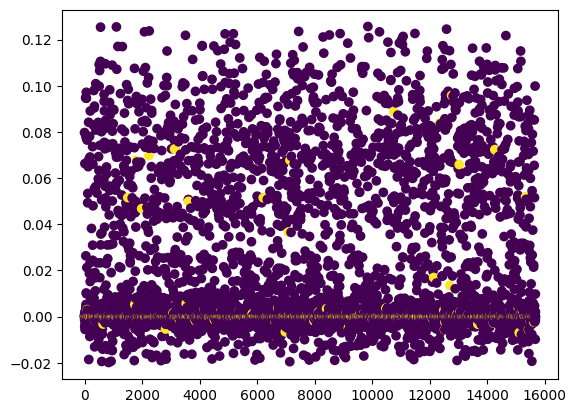

In [111]:
min, max = .01, .99
c1 = x_train_c_.T[0][x_train_c_.T[0] < np.quantile(x_train_c_.T[0], max)]
c_1 = c1[c1 > np.quantile(x_train_c_.T[0], min)]

y = y_train[x_train_c_.T[0] < np.quantile(x_train_c_.T[0], max)]
y = y[c1 > np.quantile(x_train_c_.T[0], min)]

plt.scatter([i for i in range(len(c_1))], c_1, c=y)

In [112]:
cl_ = LogisticRegression(class_weight="balanced").fit(c_1.reshape(-1, 1), y)
cl_.score(c_1.reshape(-1, 1), y)

0.3142857142857143

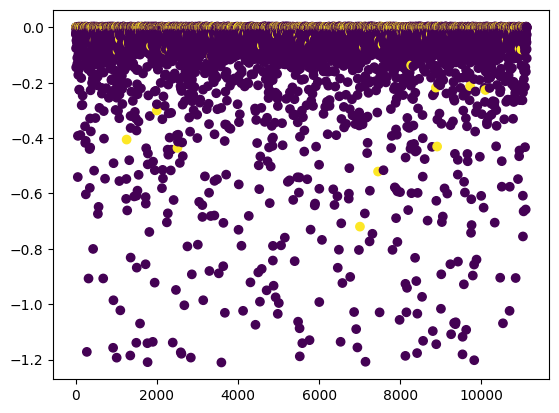

In [123]:
min, max = .01, .95
c1 = x_train_c_.T[2][x_train_c_.T[2] < np.quantile(x_train_c_.T[1], max)]
c_1 = c1[c1 > np.quantile(x_train_c_.T[2], min)]

y = y_train[x_train_c_.T[2] < np.quantile(x_train_c_.T[1], max)]
y = y[c1 > np.quantile(x_train_c_.T[2], min)]

plt.scatter([i for i in range(len(c_1))], c_1, c=y)

In [114]:
cl_ = LogisticRegression(class_weight="balanced").fit(c_1.reshape(-1, 1), y)
cl_.score(c_1.reshape(-1, 1), y)

0.8011303191489362

In [116]:
comps = pd.DataFrame(x_train_c_)
comps[3] = y_train
comps = comps[comps[0] < np.quantile(comps[0], .95)]
comps = comps[comps[0] > np.quantile(comps[0], .05)]
comps = comps[comps[1] < np.quantile(comps[0], .95)]
comps = comps[comps[1] > np.quantile(comps[0], .05)]

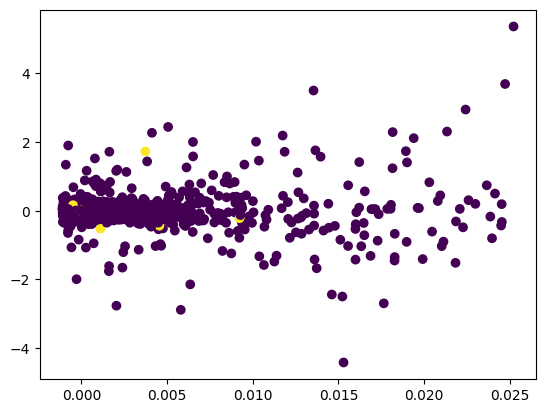

In [122]:
plt.scatter(comps[1], comps[2], c=comps[3])

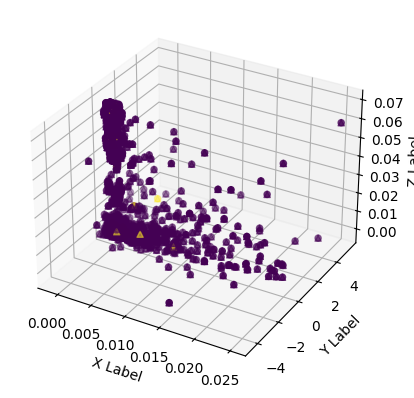

In [125]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = comps[1]
    ys = comps[2]
    zs = comps[0]
    ax.scatter(xs, ys, zs, marker=m, c= comps[3])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [23]:
from sklearn.decomposition import PCA

In [82]:
pca = PCA(n_components=2, svd_solver='arpack')
comps = pca.fit_transform(x_train_c)

dev_comp = pca.transform(x_dev_c)

In [83]:
cl_pca = LogisticRegression(class_weight="balanced").fit(comps, y_train)
print(f'Train Accuracy:{cl_pca.score(comps, y_train):.3f}, Train F1:{f1_score(y_train, cl_pca.predict(comps)):.3f}\
        Test Accuracy: {cl_pca.score(dev_comp, y_dev):.3f}, Test F1:{f1_score(y_dev, cl_pca.predict(dev_comp)):.3f}')

Train Accuracy:0.190, Train F1:0.316        Test Accuracy: 0.504, Test F1:0.668


In [85]:
from sklearn.svm import SVC
svm = SVC().fit(comps, y_train)
print(f'Train Accuracy:{svm.score(comps, y_train):.3f}, Train F1:{f1_score(y_train, svm.predict(comps)):.3f}\
        Test Accuracy: {svm.score(dev_comp, y_dev):.3f}, Test F1:{f1_score(y_dev, svm.predict(dev_comp)):.3f}')

Train Accuracy:0.812, Train F1:0.000        Test Accuracy: 0.500, Test F1:0.000
